In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
# import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [4]:
info = get_info(sfreq=100)
fwd = create_forward_model(sampling="ico3", info=info)
leadfield = util.unpack_fwd(fwd)[1]

# Simulate

In [27]:
n_samples = 2
settings = dict(duration_of_trial=2, extents=(1,40), number_of_sources=(1,10), target_snr=3, beta=5, beta_noise=4)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 11.30it/s]


No projector specified for this dataset. Please consider the method self.add_proj.


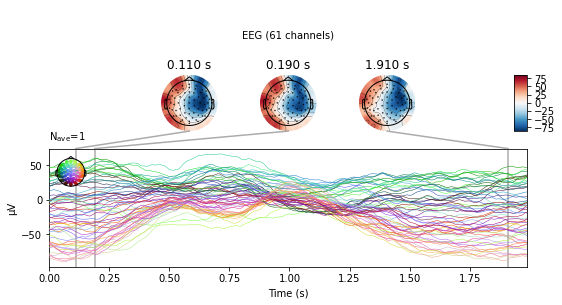

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
No projector specified for this dataset. Please consider the method self.add_proj.


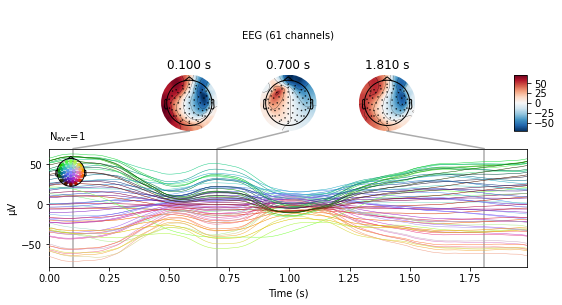

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
No projector specified for this dataset. Please consider the method self.add_proj.


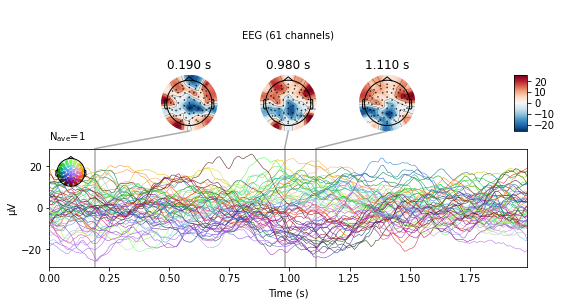

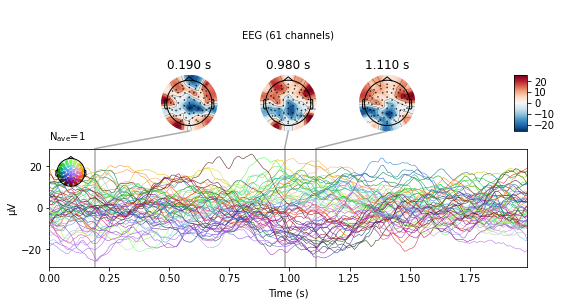

In [28]:
source = sim.source_data[0].data
eeg_clean = leadfield @ source
evoked = sim.eeg_data[0].copy().average()
evoked.plot_joint()

evoked_signal =evoked.copy() 
evoked_signal.data = eeg_clean
evoked_signal.set_eeg_reference()
evoked_signal.plot_joint()

evoked_noise = evoked.copy()
evoked_noise.data = evoked.data - evoked_signal.data
evoked_noise.set_eeg_reference()
evoked_noise.plot_joint()

No projector specified for this dataset. Please consider the method self.add_proj.


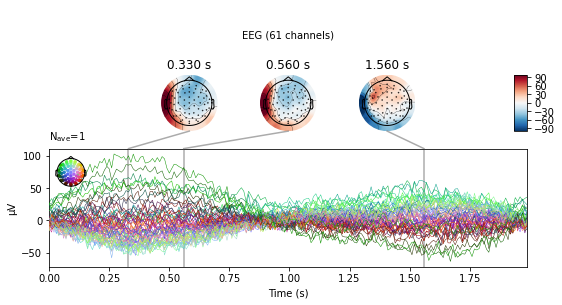

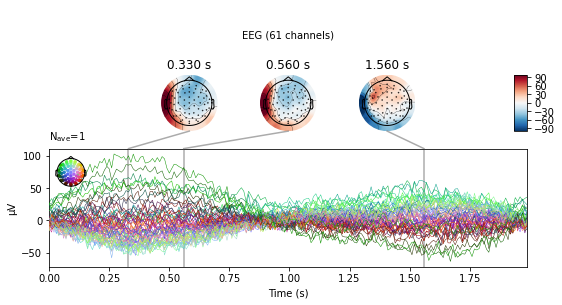

In [20]:
evoked = sim.eeg_data[0].average()
evoked.plot_joint()

No projector specified for this dataset. Please consider the method self.add_proj.


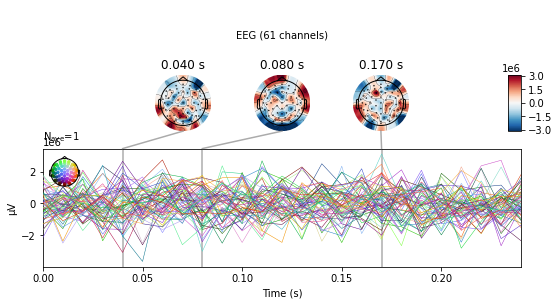

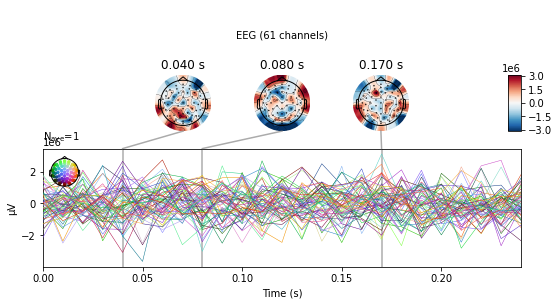

In [8]:
import numpy as np
noise = np.random.randn(*evoked.data.shape)
evoked_noise = evoked.copy()
evoked_noise.data = noise
evoked_noise.plot_joint()

# Spatially colored noise

## Grid

In [235]:
import numpy as np
from copy import deepcopy
from mne.channels.layout import _find_topomap_coords
info = deepcopy(evoked.info)

exponent = 0
n = 100
n_time = sim.eeg_data[0].average().times.size
shape = (n,n,n_time)
elec_pos = _find_topomap_coords(info, info.ch_names)
x = np.linspace(elec_pos[:, 0].min(), elec_pos[:, 0].max(), num=shape[0])
y = np.linspace(elec_pos[:, 1].min(), elec_pos[:, 1].max(), num=shape[1])

k_neighbors = 5
grid = np.stack(np.meshgrid(x,y, indexing='ij'), axis=0)
grid_flat = grid.reshape(grid.shape[0], np.product(grid.shape[1:])).T
neighbor_indices = np.stack([
    np.argsort(np.sqrt(np.sum((grid_flat - coords)**2, axis=1)))[:k_neighbors] for coords in elec_pos
], axis=0)

grid = {
    "shape": shape,
    "k_neighbors": k_neighbors,
    "exponent": exponent,
    "x": x,
    "y": y,
    "grid": grid,
    "grid_flat": grid_flat,
    "neighbor_indices": neighbor_indices
}


In [236]:
from esinet import util
noise_grid = util.create_n_dim_noise(grid["shape"], exponent=grid["exponent"])

In [237]:
k_neighbors = 5
grid_flat = grid["grid"].reshape(2, n*n)
noise_elec = np.zeros((elec_pos.shape[0], n_time))
for e, e_pos in enumerate(elec_pos):
    for t in range(n_time):
        neighbor_idc = np.argsort(np.sum((grid_flat.T - e_pos)**2, axis=1))[:k_neighbors]
        noise_transformed = np.mean(noise_grid[:, :, t].flatten()[neighbor_idc])
        noise_elec[e, t] = noise_transformed

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


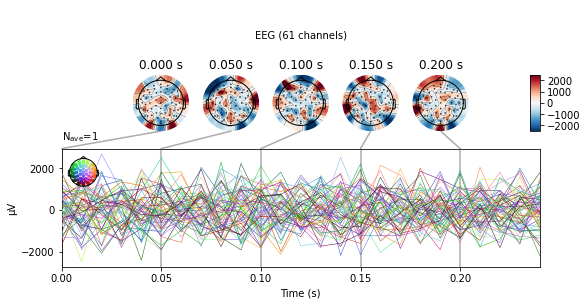

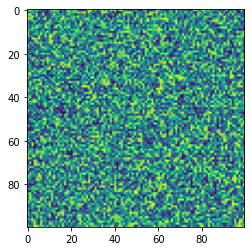

In [238]:
noise_elec.shape
evoked_noise = evoked.copy()
evoked_noise.data = noise_elec
evoked_noise.set_eeg_reference("average", projection=True)
evoked_noise.plot_joint(times=[0, 0.05, 0.1, 0.15, 0.2])
plt.figure()
plt.imshow(noise_grid[:, :, 0])

In [9]:
import numpy as np
from copy import deepcopy
from mne.channels.layout import _find_topomap_coords

class NoiseGenerator:
    def __init__(self, info):
        self.info = info
        self.prepare()
        pass
    def prepare(self, resolution=16, k_neighbors=5):
        
        # n_time = sim.eeg_data[0].average().times.size
        # shape = (resolution, resolution, n_time)
        self.elec_pos = _find_topomap_coords(info, info.ch_names)
        x = np.linspace(self.elec_pos[:, 0].min(), self.elec_pos[:, 0].max(), num=resolution)
        y = np.linspace(self.elec_pos[:, 1].min(), self.elec_pos[:, 1].max(), num=resolution)

        grid = np.stack(np.meshgrid(x,y, indexing='ij'), axis=0)
        grid_flat = grid.reshape(2, resolution**2)

        # grid_flat = grid.reshape(grid.shape[0], np.product(grid.shape[1:])).T
        neighbor_indices = np.stack([
            np.argsort(np.sqrt(np.sum((grid_flat.T - coords)**2, axis=1)))[:k_neighbors] for coords in self.elec_pos
        ], axis=0)

        self.resolution = resolution
        self.grid = grid
        self.grid_flat = grid_flat
        self.k_neighbors = k_neighbors
        self.neighbor_indices = neighbor_indices
        

    def get_noise(self, n_time, exponent=2):
        noise_grid = util.create_n_dim_noise((self.resolution, self.resolution, n_time), exponent=exponent)
        noise_elec = np.zeros((self.elec_pos.shape[0], n_time))
        for e, e_pos in enumerate(self.elec_pos):
            for t in range(n_time):
                # neighbor_idc = np.argsort(np.sum((self.grid_flat.T - e_pos)**2, axis=1))[:self.k_neighbors]
                neighbor_idc = self.neighbor_indices[e,:]
                noise_transformed = np.mean(noise_grid[:, :, t].flatten()[neighbor_idc])
                noise_elec[e, t] = noise_transformed
        return noise_elec

In [11]:
gen = NoiseGenerator(evoked.info)
gen.get_noise(100)

array([[-1.28586707e-03, -2.19463562e-04, -4.28785549e-04, ...,
        -4.32230506e-04, -6.40300334e-04, -7.95826253e-04],
       [ 3.11438126e-04,  2.65233291e-04,  3.23059649e-04, ...,
         4.14343308e-05,  3.84785934e-04,  6.64748882e-04],
       [ 5.15741827e-04,  1.11563402e-03,  2.80124316e-04, ...,
         3.98617262e-04,  7.50515990e-04,  1.27798331e-03],
       ...,
       [-7.27265624e-04, -7.71857800e-04,  4.99313200e-04, ...,
         3.53188444e-04, -5.38645429e-04, -7.50300040e-04],
       [-2.78177150e-04,  7.21373720e-05,  4.98142971e-04, ...,
        -1.52952304e-04, -3.82285771e-04, -1.19073240e-04],
       [-1.69716611e-04,  1.29181465e-04,  7.30358695e-04, ...,
         6.76072640e-04,  4.16421579e-04,  1.15909739e-04]])